In [1]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to c:\users\hp\appdata\local\temp\pip-req-build-oaxca1wm
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/54.4 kB ? eta -:--:--
   ---------------------- ----------------- 30.7/54.4 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 54.4/54.4 kB 940.3 kB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369579 sha256=77bb6b5619eccaa73ca075072160a7e10b4a5778f66ecd18915581b7a1994cb8
  Stored in directory: C:\Users\hp\AppData\Local\Temp\pip-ephem-wheel-cache-1dnb1qrp\wheels\3f\7c\a4\9b490845988bf7a4db33674d52f709f088f64392063872eb9a
Successfully built clip
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.5
    Uninstalling wcwidth-0.2.5:
      Successfully uninstalled wcwidth

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git 'C:\Users\hp\AppData\Local\Temp\pip-req-build-oaxca1wm'


In [1]:
import torch
import clip
from torchsummary import summary
from PIL import Image
import json
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms
import numpy as np
import time
import torchvision.models as models

In [2]:
import urllib.request

# Download ImageNet labels and save to colab environment
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
urllib.request.urlretrieve(url, "imagenet_labels.txt")

('imagenet_labels.txt', <http.client.HTTPMessage at 0x1e35fc623d0>)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device : ",device)

device :  cuda


# 1.) Setup Models

In [4]:
# initializing ImageNet pretraining (from torchivision.models)
model1 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)

# initializing OpenAIs CLIP
model2, preprocess = clip.load("RN50", device=device)

# image and text encoder seperated
vision_encoder = model2.encode_image
text_encoder = model2.encode_text

### Do the visual encoders have the same architecture? If not, please describe and explain the differences. Also differentiate b/w text and image encoders.


Certainly! Let's compare the architectures of CLIP with ResNet50:

**CLIP (Contrastive Language-Image Pretraining):**

- Architecture Overview: CLIP is a vision-language transformer model that learns to associate images and text in a joint embedding space. It consists of two main components: the image encoder and the text encoder.
- Image Encoder: CLIP's image encoder processes input images using a convolutional neural network (CNN) backbone, followed by a multi-layer perceptron (MLP) head. The CNN backbone extracts visual features from the input image, which are then processed by the MLP head to produce image embeddings.
- Text Encoder: CLIP's text encoder processes input text prompts using a transformer-based architecture, similar to models like BERT. It tokenizes the input text, passes it through transformer layers, and produces text embeddings.
- Joint Embedding Space: CLIP learns to map images and text into a shared embedding space, where semantically similar images and text prompts are placed close together.


**ResNet50 (Residual Network):**

- Architecture Overview: ResNet50 is a convolutional neural network (CNN) architecture designed for image classification tasks. It consists of multiple residual blocks, each containing convolutional layers, batch normalization, and shortcut connections (residual connections).
- Residual Blocks: ResNet50 employs residual blocks with skip connections that bypass one or more convolutional layers. These skip connections help mitigate the vanishing gradient problem and enable the network to learn more effective representations.
- Layer Stacking: ResNet50 stacks multiple residual blocks, with increasing numbers of filters in each block. The deeper layers capture increasingly abstract and high-level features of the input image.
- Global Average Pooling and Fully Connected Layer: After the convolutional layers, ResNet50 typically applies global average pooling to reduce spatial dimensions and flatten feature maps. It then uses one or more fully connected layers to produce class predictions.


### Architectural Differences


1. Task Orientation: CLIP is designed for vision-language tasks, where it learns to understand the relationship between images and text. ResNet50, on the other hand, is specifically tailored for image classification tasks.
2. Model Complexity: CLIP incorporates both vision and language processing components, making it a more complex and versatile model compared to ResNet50, which focuses solely on visual feature extraction.
3. Training Objective: CLIP is trained to maximize agreement between image and text embeddings across a diverse range of tasks and datasets. ResNet50 is typically trained with supervised learning on large-scale image classification datasets like ImageNet, optimizing for accurate class predictions.



In [14]:
torch.save(model1.state_dict(), 'Imagenet_pretrained_RN50.pth')
torch.save(model2, 'clip_model_RN50.pth')

# 2.) Setup Data


**Q.) What label hierarchy is used in ImageNet?**

**A.)** ImageNet uses a hierarchical structure for its labels, where each label represents a category of objects or concepts. The hierarchy is organized into a tree-like structure, with parent nodes representing broader categories and child nodes representing more specific subcategories. This hierarchical organization allows for a systematic way to organize and navigate the large number of labels in the dataset.




**Q.) What does a synset mean?**

**A.)** In ImageNet, a synset (synonym set) is a collection of synonymous words or phrases that describe the same concept or object category. Each synset is assigned a unique identifier, and it corresponds to a specific label or category in the ImageNet dataset. Synsets provide a standardized way to represent object categories and facilitate consistency in labeling across different images.


**Q.) Could grouping objects based on synsets lead to problems for visual recognition?**

**A.)** While grouping objects based on synsets provides a structured and systematic way to organize the dataset, it can lead to challenges for visual recognition in some cases. One potential issue is the inherent variability and diversity within synsets. Objects belonging to the same synset may exhibit significant visual differences in appearance, shape, texture, color, and context. This variability can pose challenges for models trained on ImageNet to accurately recognize and classify objects, especially when faced with diverse visual inputs.




**Q.) State 3 types of visual differences we can expect to see in images with objects corresponding to the same synset?**

**A.)** Despite belonging to the same synset, objects in images may exhibit various visual differences that can affect recognition. Here are three types of visual differences we can expect to see:

1. ***Appearance Variability:*** Objects within the same synset can vary widely in appearance due to factors such as variations in pose, lighting conditions, occlusions, background clutter, and viewpoint changes. For example, different breeds of dogs or species of birds may have distinct appearances despite belonging to the same synset.

2. ***Scale and Size Differences:*** Objects within the same synset may appear at different scales or sizes in images. For instance, a small dog and a large dog may both belong to the synset "dog," but they may occupy different portions of the image and exhibit different scales relative to other objects.

3. ***Contextual Variations:*** Objects within the same synset may appear in different contextual settings or scenes, leading to variations in appearance and surroundings. For example, a "car" may appear on a road, in a parking lot, or amidst traffic, each with distinct contextual cues that influence its appearance and recognition.




# 3.) Setup zero-shot CLIP

## Function to infer from CLIP

In [5]:
# function to generate probability scores for ImageNet categories
def get_imagenet_probs(image_path):
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model2.encode_image(image_input)

    text = ["a photo of a " + label for label in imagenet_labels]
    text_tokens = clip.tokenize(text).to(device)
    with torch.no_grad():
        text_features = model2.encode_text(text_tokens)

    similarity_scores = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    return similarity_scores.squeeze().cpu().numpy()


## Inferring for a few example images

***Note :*** In all the examples, the detection 'works well'

In [6]:
# Load ImageNet class labels
with open("imagenet_labels.txt", "r") as f:
    imagenet_labels = [label.strip() for label in f.readlines()]


# Test with example images
example_images = ["example_image1.jpg", "example_image2.jpg", "example_image3.jpg", "example_image4.jpg",
                  "example_image5.jpg","example_image6.jpg","example_image7.jpg","example_image8.jpg",
                  "example_image9.jpg","example_image10.jpg","example_image11.jpg","example_image12.jpg",
                  "example_image13.jpg","example_image14.jpg","example_image15.jpg"]

# example_images = ["./images/broken_pole.jpg","./images/car_in_a_desert.jpg","./images/dog_swimming.jpg",
#                   "./images/restraunt_from_inside.jpg","./images/volcano_from_top.jpg","./images/zoomed_melted_icecream.jpg",
#                   "./images/shipwreck.jpg","./images/aircraft.jpg","./images/crashed_aircraft.jpg","./images/satellite_venice.jpg",
#                  "./images/stop_sign.jpg","./images/zebra_hiding.jpg","./images/designer_tray.jpg","./images/inside_dishwasher.jpg",
#                  "./images/inside_garbage_truck.jpg","./images/solved_jigsaw_puzzle.jpg","./images/zoomed_seashore.jpg",
#                  "./images/projector_from_front.jpg","./images/blurred_scubadiver.jpg","./images/crashed_car.jpg","./images/dam_viewed_from_top.jpg",
#                  "./images/fingernails.jpg","./images/nails_tools.jpg"]


for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices

    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print()  # Print an empty line for separation between images
#     break


C:\Users\hp\anaconda3\Lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Top 5 predicted classes for example_image1.jpg :
1. "Golden Retriever",: 99.90%
2. "Labrador Retriever",: 0.09%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%

Top 5 predicted classes for example_image2.jpg :
1. "folding chair",: 92.43%
2. "cradle",: 7.59%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%

Top 5 predicted classes for example_image3.jpg :
1. "mountain bike",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for example_image4.jpg :
1. "jay",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for example_image5.jpg :
1. "convertible",: 81.74%
2. "sports car",: 18.24%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%

Top 5 predicted classes for example_image6.jpg :
1. "mask",: 100.00%
2. "titi",: 0.00%
3. "tiger shark",: 0.00%
4. 

## Function to infer from pretrained RN50 on ImageNet

In [7]:
def infer_ImageNet_pretraining(image_path):
  # Load ImageNet labels
  with open("imagenet_labels.txt") as f:
      labels = json.load(f)

  # Define image preprocessing
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  # Load and preprocess the image
  # image_path = "example_image1.jpg"
  image = Image.open(image_path)
  input_tensor = preprocess(image)
  input_batch = input_tensor.unsqueeze(0)  # Add batch dimension

  # Move input tensor to the appropriate device
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  input_batch = input_batch.to(device)

  # Perform inference
  with torch.no_grad():
      model1.eval()  # Set model to evaluation mode
      output = model1(input_batch)

  # Get top-5 predicted classes and probabilities
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  top5_prob, top5_indices = torch.topk(probabilities, 5)

  # Convert indices to labels
  top5_labels = [labels[index] for index in top5_indices]

  # Output top-5 labels with probabilities
  for label, prob in zip(top5_labels, top5_prob):
      print("Label:", label)
      print("Probability:", round(prob.item(),4))




## Inferring for a few example images

In [8]:
for image_path in example_images:
  print("_____________________________________________________")
  print("Pre-trained Imagenet results for ",image_path,"\n")
  infer_ImageNet_pretraining(image_path)
  print("_____________________________________________________")

_____________________________________________________
Pre-trained Imagenet results for  example_image1.jpg 

Label: Golden Retriever
Probability: 0.8872
Label: Labrador Retriever
Probability: 0.094
Label: Brittany Spaniel
Probability: 0.0035
Label: tennis ball
Probability: 0.0018
Label: Cocker Spaniels
Probability: 0.0011
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  example_image2.jpg 

Label: dining table
Probability: 0.4012
Label: rocking chair
Probability: 0.3725
Label: folding chair
Probability: 0.093
Label: pedestal
Probability: 0.0334
Label: barber chair
Probability: 0.013
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  example_image3.jpg 

Label: mountain bike
Probability: 0.8819
Label: tandem bicycle
Probability: 0.1163
Label: disc brake
Probability: 0.0007
Label: tricycle
Probability: 0.00

# 4.) CLIP vs ImageNet pretraining

We pick 10 classes and for each class

- Find 2 images that work well with CLIP, but not with ImageNet pretrained RN50. Reason about why this
may be the case. From where did you get these images?

- Find 1 image that works well with ImageNet pretraining but not CLIP. Reason about why this may be the
case. From where did you get these images?


### class 1 : Dandie Dinmont Terrier (a dog)

In [44]:
with open("imagenet_labels.txt", "r") as f:
    imagenet_labels = [label.strip() for label in f.readlines()]

example_images = ["./class1/dog_swimming.jpg","./class1/dog1.jpg","class1/dog2.jpg"]

In [65]:
# CLIP
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices

    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print()


Top 5 predicted classes for ./class1/dog_swimming.jpg :
1. "yawl",: 99.90%
2. "Maltese",: 0.09%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%

Top 5 predicted classes for ./class1/dog1.jpg :
1. "Dandie Dinmont Terrier",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for class1/dog2.jpg :
1. "Dandie Dinmont Terrier",: 100.00%
2. "lion",: 0.00%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%



In [46]:
# RN50 in Imagenet
for image_path in example_images:
  print("_____________________________________________________")
  print("Pre-trained Imagenet results for ",image_path,"\n")
  infer_ImageNet_pretraining(image_path)
  print("_____________________________________________________")

_____________________________________________________
Pre-trained Imagenet results for  ./class1/dog_swimming.jpg 

Label: Dandie Dinmont Terrier
Probability: 0.3609
Label: Soft-coated Wheaten Terrier
Probability: 0.1684
Label: Irish Wolfhound
Probability: 0.1625
Label: Sealyham Terrier
Probability: 0.0562
Label: Otterhound
Probability: 0.0437
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  ./class1/dog1.jpg 

Label: Dandie Dinmont Terrier
Probability: 0.9997
Label: Miniature Poodle
Probability: 0.0
Label: Standard Schnauzer
Probability: 0.0
Label: Miniature Schnauzer
Probability: 0.0
Label: Toy Poodle
Probability: 0.0
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  class1/dog2.jpg 

Label: Border Terrier
Probability: 0.2877
Label: Soft-coated Wheaten Terrier
Probability: 0.1362
Label: Dandie Dinmont 

### class 2 : dishwasher

In [ ]:
with open("imagenet_labels.txt", "r") as f:
    imagenet_labels = [label.strip() for label in f.readlines()]

example_images = ["./class2/inside_dishwasher.jpg","./class2/dishwasher1.jpg","class2/dishwasher2.jpg"]

In [48]:
# CLIP
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices

    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print()


Top 5 predicted classes for ./class2/inside_dishwasher.jpg :
1. "bubble",: 100.00%
2. "balloon",: 0.00%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%

Top 5 predicted classes for ./class2/dishwasher1.jpg :
1. "dishwasher",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for class2/dishwasher2.jpg :
1. "dishwasher",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%



In [49]:
# RN50 in Imagenet
for image_path in example_images:
  print("_____________________________________________________")
  print("Pre-trained Imagenet results for ",image_path,"\n")
  infer_ImageNet_pretraining(image_path)
  print("_____________________________________________________")

_____________________________________________________
Pre-trained Imagenet results for  ./class2/inside_dishwasher.jpg 

Label: dishwasher
Probability: 0.3399
Label: Petri dish
Probability: 0.2414
Label: shower cap
Probability: 0.122
Label: plate rack
Probability: 0.1218
Label: toilet seat
Probability: 0.0507
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  ./class2/dishwasher1.jpg 

Label: dishwasher
Probability: 0.9946
Label: plate rack
Probability: 0.0037
Label: refrigerator
Probability: 0.0007
Label: weighing scale
Probability: 0.0005
Label: photocopier
Probability: 0.0001
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  class2/dishwasher2.jpg 

Label: dishwasher
Probability: 0.9674
Label: rotisserie
Probability: 0.0101
Label: plate rack
Probability: 0.002
Label: tobacco shop
Probability: 0.0017
Lab

### class 3 : jigsaw puzzle

In [50]:
# class1 : Dandie Dinmont Terrier (dog)
with open("imagenet_labels.txt", "r") as f:
    imagenet_labels = [label.strip() for label in f.readlines()]

example_images = ["./class3/solved_jigsaw_puzzle.jpg","./class3/puzzle1.jpg","class3/puzzle2.jpg"]

In [51]:
# CLIP
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices

    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print()


Top 5 predicted classes for ./class3/solved_jigsaw_puzzle.jpg :
1. "valley",: 100.00%
2. "promontory",: 0.00%
3. "hay",: 0.00%
4. "quilt",: 0.00%
5. "tiger shark",: 0.00%

Top 5 predicted classes for ./class3/puzzle1.jpg :
1. "jigsaw puzzle",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for class3/puzzle2.jpg :
1. "jigsaw puzzle",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%



In [55]:
# RN50 in Imagenet
for image_path in example_images:
  print("_____________________________________________________")
  print("Pre-trained Imagenet results for ",image_path,"\n")
  infer_ImageNet_pretraining(image_path)
  print("_____________________________________________________")

_____________________________________________________
Pre-trained Imagenet results for  ./class3/solved_jigsaw_puzzle.jpg 

Label: jigsaw puzzle
Probability: 0.5237
Label: wool
Probability: 0.1039
Label: poncho
Probability: 0.0979
Label: scarf
Probability: 0.0449
Label: cardigan
Probability: 0.042
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  ./class3/puzzle1.jpg 

Label: jigsaw puzzle
Probability: 0.9902
Label: comic book
Probability: 0.0006
Label: Band-Aid
Probability: 0.0005
Label: tray
Probability: 0.0005
Label: coffee mug
Probability: 0.0003
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  class3/puzzle2.jpg 

Label: jigsaw puzzle
Probability: 1.0
Label: ballpoint pen
Probability: 0.0
Label: eraser
Probability: 0.0
Label: syringe
Probability: 0.0
Label: window screen
Probability: 0.0
___________

### class 4 : projector

In [59]:
with open("imagenet_labels.txt", "r") as f:
    imagenet_labels = [label.strip() for label in f.readlines()]

example_images = ["./class4/projector_from_front.jpg","./class4/projector1.jpg","class4/projector2.jpg"]

In [60]:
# CLIP
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices

    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print()


Top 5 predicted classes for ./class4/projector_from_front.jpg :
1. "website",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for ./class4/projector1.jpg :
1. "projector",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for class4/projector2.jpg :
1. "projector",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%



In [61]:
# RN50 in Imagenet
for image_path in example_images:
  print("_____________________________________________________")
  print("Pre-trained Imagenet results for ",image_path,"\n")
  infer_ImageNet_pretraining(image_path)
  print("_____________________________________________________")

_____________________________________________________
Pre-trained Imagenet results for  ./class4/projector_from_front.jpg 

Label: projector
Probability: 0.4642
Label: CRT screen
Probability: 0.1557
Label: spotlight
Probability: 0.061
Label: monitor
Probability: 0.0501
Label: television
Probability: 0.0262
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  ./class4/projector1.jpg 

Label: projector
Probability: 0.9999
Label: binoculars
Probability: 0.0001
Label: reflex camera
Probability: 0.0
Label: Polaroid camera
Probability: 0.0
Label: loupe
Probability: 0.0
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  class4/projector2.jpg 

Label: projector
Probability: 0.9999
Label: spotlight
Probability: 0.0
Label: desktop computer
Probability: 0.0
Label: CD player
Probability: 0.0
Label: notebook computer
Prob

### class 5 : scubadiver

In [62]:
with open("imagenet_labels.txt", "r") as f:
    imagenet_labels = [label.strip() for label in f.readlines()]

example_images = ["./class5/blurred_scubadiver.jpg","./class5/scubadiver1.jpg","class5/scubadiver2.jpg"]

In [63]:
# CLIP
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices

    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print()


Top 5 predicted classes for ./class5/blurred_scubadiver.jpg :
1. "shoal",: 100.00%
2. "coral reef",: 0.00%
3. "scuba diver",: 0.00%
4. "tiger shark",: 0.00%
5. "goldfish",: 0.00%

Top 5 predicted classes for ./class5/scubadiver1.jpg :
1. "scuba diver",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%

Top 5 predicted classes for class5/scubadiver2.jpg :
1. "scuba diver",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%



In [64]:
# RN50 in Imagenet
for image_path in example_images:
  print("_____________________________________________________")
  print("Pre-trained Imagenet results for ",image_path,"\n")
  infer_ImageNet_pretraining(image_path)
  print("_____________________________________________________")

_____________________________________________________
Pre-trained Imagenet results for  ./class5/blurred_scubadiver.jpg 

Label: scuba diver
Probability: 0.4201
Label: snorkel
Probability: 0.2438
Label: coral reef
Probability: 0.1177
Label: sea snake
Probability: 0.0678
Label: electric ray
Probability: 0.0455
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  ./class5/scubadiver1.jpg 

Label: scuba diver
Probability: 0.9172
Label: sea snake
Probability: 0.0124
Label: snorkel
Probability: 0.0119
Label: coral reef
Probability: 0.0097
Label: electric ray
Probability: 0.0096
_____________________________________________________
_____________________________________________________
Pre-trained Imagenet results for  class5/scubadiver2.jpg 

Label: scuba diver
Probability: 0.7536
Label: snorkel
Probability: 0.2379
Label: gas mask
Probability: 0.003
Label: snowmobile
Probability: 0.0014
Label: oxygen mas

## Analysis of the results

ResNet 50 Advantages (Imagenet Strengths):

- **Classic ImageNet Categories**: ResNet was trained on ImageNet, a massive dataset with well-defined categories like animals, objects, and everyday scenes. Look for images that fall squarely within these categories, featuring clear and isolated objects with minimal background clutter
- **Fine-grained Details:** ResNet excels at recognizing subtle variations within a class it's familiar with. Look for images where fine details differentiate one object from another. Examples include:


---


1. ResNet, trained on a massive dataset of clear images, thrives on recognizing common objects even with partial views. Its strength lies in identifying patterns and shapes. CLIP, however, leverages text descriptions. So, a partially submerged dog, where key features are hidden, might confuse CLIP as it lacks the complete visual picture. ResNet, on the other hand, might still recognize the dog based on the visible part and its knowledge of dog shapes from various poses learned during training

2. CLIP and ResNet tackle object recognition in different ways. CLIP relies on understanding the bigger picture and the relationship between objects and their surroundings. An image from inside a dishwasher might be a completely new scene for CLIP, lacking the context it needs for identification. Additionally, CLIP might not have been trained on many dishwasher interiors. ResNet, on the other hand, benefits from its training on a vast image collection, including household objects. It might recognize individual components within the dishwasher (racks, sprayers) or leverage its understanding of how parts make up a whole to identify the dishwasher even from a limited view.

3. In our case, for example, the pretrained imagenet identifies fine-grained features such as shapes of jigsaw puzzle even when it is fullly solved and focuses on the extracted features more than the overall picture, which is a scenery. However, in case of CLIP, textual reasoning plays a major role and the model sees the whole image in the textual context and weighs less importance to the fine-grained features, thus focusing on the scenery and ignoring the puzzle patterns. 


4. CLIP might get tripped up by a straight-on projector image. It leans on text cues and might look for surrounding elements, which a front view projector lacks. Additionally, CLIP's training might have missed frontal views altogether. Thankfully, ResNet excels here. Trained on a vast object library including projectors, ResNet can recognize the projector's shape, lens, and vents even from this unfamiliar angle..

5. A blurred scuba diver might confuse CLIP but be recognized by a pre-trained ResNet on ImagenetCLIP relies on clear visuals and their relationship to text descriptions. A blurred image makes it difficult for CLIP to identify key features and match them to its text database. Scuba gear details like fins, air tanks, and masks might be obscured in the blur, making it hard for CLIP to identify the diver based on these specific elements. Trained on ImageNet with numerous images, ResNet excels at recognizing patterns and shapes. Even with blur, it might identify the overall diver silhouette based on its training data. While details are blurry, ResNet might recognize larger shapes like the air tank or fins as hints towards a diver, even if a complete picture is unavailable.

---

**CLIP Challenges:**
- Limited Viewpoint Training: CLIP might struggle with objects shown from unfamiliar perspectives.
- Reliance on Clarity: Blurry or incomplete images can hinder CLIP's ability to identify objects.
- Context Dependence: CLIP prioritizes the relationship between objects and their surroundings, which can be misleading in certain situations.

**ResNet Strengths (ImageNet Pre-training):**
- Object-Centric Recognition: ResNet excels at recognizing objects themselves, independent of context.
- Part Recognition: It can identify individual components of objects, aiding recognition even with partial views.
- Pattern Recognition: ResNet excels at recognizing patterns and shapes associated with objects, allowing for identification even in less-than-ideal images.

---
**ResNet Challenges (ImageNet Pre-training):**

- Limited to Known Categories: ResNet struggles with entirely new objects or concepts not included in its training data (ImageNet).
- Context Blindness: It might struggle to understand the relationship between objects and their surroundings, leading to misinterpretations.
- Specificity for Uncommon Objects: For less common objects, ResNet might not have the same level of detail and accuracy compared to more frequently encountered ones.

**CLIP Strengths:**

- Understanding Context: CLIP leverages the relationship between objects and their surroundings, aiding recognition in situations where context is crucial.
- Novel Object Handling: CLIP's text-based training allows it to handle some uncommon objects by relating them to textual descriptions, even if they weren't directly encountered during training.
- Adaptability to New Concepts: With proper fine-tuning using text and image pairs, CLIP can potentially adapt to new categories of objects that weren't present in its initial training data.


Also, we can see from the CLIP paper that for some datasets, CLIP underperforms Imagenet

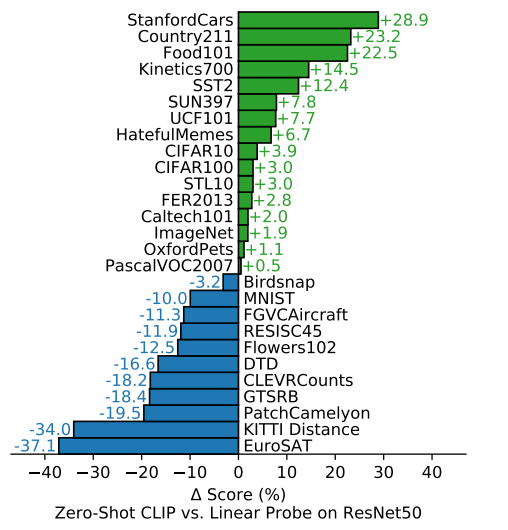

*"we see that zero-shot CLIP is quite weak on several specialized, complex, or abstract tasks such as satellite image
classification (EuroSAT and RESISC45), lymph node tumor
detection (PatchCamelyon), counting objects in synthetic
scenes (CLEVRCounts), self-driving related tasks such as
German traffic sign recognition (GTSRB), recognizing distance to the nearest car (KITTI Distance). These results
highlight the poor capability of zero-shot CLIP on more
complex tasks."*

# 5.) Memory optimizations with FP16

## 5.1) Comparison of time required to encode an image

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_fp32, _ = clip.load("RN50", device=device)

model_fp16 = model_fp32.half()

image_path = "example_image1.jpg"
image = Image.open(image_path)
image = preprocess(image).unsqueeze(0).to(device)

num_runs = 100
inference_times_fp32 = []
inference_times_fp16 = []

for _ in range(num_runs):
    # For fp32 model
    start_time_fp32 = time.time()
    with torch.no_grad():
        output_fp32 = model_fp32.encode_image(image)
    end_time_fp32 = time.time()
    inference_time_fp32 = end_time_fp32 - start_time_fp32
    inference_times_fp32.append(inference_time_fp32)

    # For fp16 model
    start_time_fp16 = time.time()
    with torch.no_grad():
        output_fp16 = model_fp16.encode_image(image)
    end_time_fp16 = time.time()
    inference_time_fp16 = end_time_fp16 - start_time_fp16
    inference_times_fp16.append(inference_time_fp16)

mean_time_fp32 = np.mean(inference_times_fp32)
std_dev_time_fp32 = np.std(inference_times_fp32)
mean_time_fp16 = np.mean(inference_times_fp16)
std_dev_time_fp16 = np.std(inference_times_fp16)

print("Mean inference time for fp32 model:", mean_time_fp32, "seconds")
print("Standard deviation for fp32 model:", std_dev_time_fp32, "seconds")
print("Mean inference time for fp16 model:", mean_time_fp16, "seconds")
print("Standard deviation for fp16 model:", std_dev_time_fp16, "seconds")

Mean inference time for fp32 model: 0.008267965316772461 seconds
Standard deviation for fp32 model: 0.0031901924860005012 seconds
Mean inference time for fp16 model: 0.008172924518585206 seconds
Standard deviation for fp16 model: 0.0015136207501058186 seconds


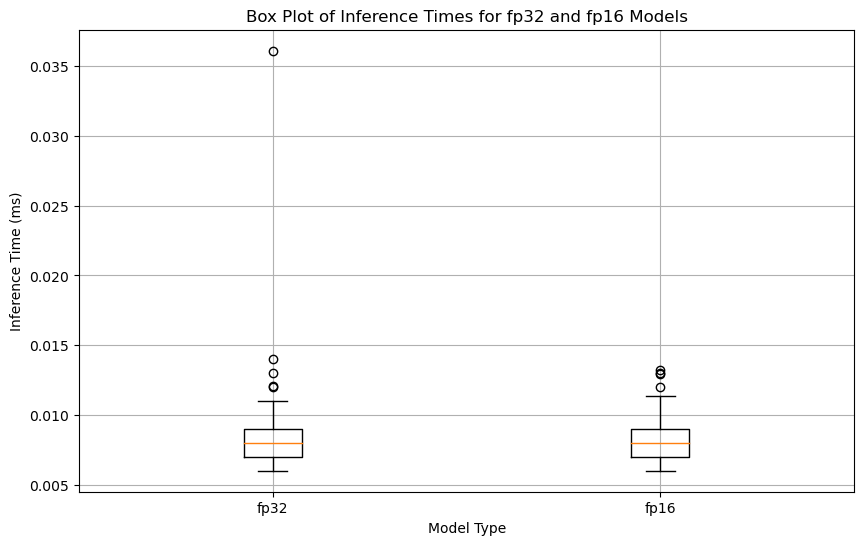

In [10]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([inference_times_fp32, inference_times_fp16], labels=['fp32', 'fp16'])
plt.xlabel('Model Type')
plt.ylabel('Inference Time (ms)')
plt.title('Box Plot of Inference Times for fp32 and fp16 Models')
plt.grid(True)
plt.show()


## 5.2) Comparison b/w outputs of fp16 and fp32 models

In [11]:
# Define a function to generate probability scores for ImageNet categories (fp16)
def get_imagenet_probs_fp16(model_fp32, model_fp16, image_path):

    # Load and preprocess the image
    image = Image.open(image_path)
    image_input = preprocess(image).unsqueeze(0).to(device)

    # Encode the image
    with torch.no_grad():
        image_features = model_fp16.encode_image(image_input)

    # Tokenize and encode the text
    text = ["a photo of a " + label for label in imagenet_labels]
    text_tokens = clip.tokenize(text).to(device)
    with torch.no_grad():
        text_features_fp32 = model_fp32.encode_text(text_tokens)

    # Convert text features to fp16
    text_features_fp16 = text_features_fp32.half()

    # Calculate cosine similarity between image and text features
    similarity_scores = (100.0 * image_features @ text_features_fp16.T).softmax(dim=-1)

    return similarity_scores.squeeze().cpu().numpy()


### Making inference for 5 example images

In [19]:
model_fp32, preprocess = clip.load("RN50", device=device)
temp, _ = clip.load("RN50", device=device)
model_fp16 = temp.half()

example_images = ["example_image1.jpg","example_image2.jpg","example_image3.jpg","example_image4.jpg","example_image5.jpg"]


### Using fp16 model

In [20]:
for image_path in example_images:
    probs = get_imagenet_probs_fp16(model_fp32, model_fp16, image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices
        
    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print("___________________________________________________________________")


Top 5 predicted classes for example_image1.jpg :
1. "Golden Retriever",: 99.95%
2. "Labrador Retriever",: 0.06%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%
___________________________________________________________________
Top 5 predicted classes for example_image2.jpg :
1. "folding chair",: 81.74%
2. "cradle",: 18.24%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%
___________________________________________________________________
Top 5 predicted classes for example_image3.jpg :
1. "mountain bike",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%
___________________________________________________________________
Top 5 predicted classes for example_image4.jpg :
1. "jay",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%
___________________________________________________________________
Top 5 predicted classes 

### Using fp32 model

In [21]:
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices
        
    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print("___________________________________________________________________")


Top 5 predicted classes for example_image1.jpg :
1. "Golden Retriever",: 99.90%
2. "Labrador Retriever",: 0.09%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%
___________________________________________________________________
Top 5 predicted classes for example_image2.jpg :
1. "folding chair",: 92.43%
2. "cradle",: 7.59%
3. "tiger shark",: 0.00%
4. "goldfish",: 0.00%
5. "hammerhead shark",: 0.00%
___________________________________________________________________
Top 5 predicted classes for example_image3.jpg :
1. "mountain bike",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%
___________________________________________________________________
Top 5 predicted classes for example_image4.jpg :
1. "jay",: 100.00%
2. "goldfish",: 0.00%
3. "tiger shark",: 0.00%
4. "hammerhead shark",: 0.00%
5. ["tench",: 0.00%
___________________________________________________________________
Top 5 predicted classes f

## Analysis if performance of fp16 and fp32

- CLIP excels at understanding the relationships between objects and their textual descriptions. This task might not be as sensitive to the higher precision offered by 32-bit floating-point numbers (FP32) compared to tasks that rely heavily on precise numerical calculations.

- In some cases, object recognition doesn't require absolute precision. Even with a slight loss of detail due to FP16, CLIP might still be able to accurately identify the main object in an image based on the dominant features it captures.

- Not all bits in a 32-bit floating-point number are crucial for representing the range of values needed by CLIP.  FP16 might be sufficient to capture the essential information for most image features relevant to CLIP's task.


***However, in general, fp32 performs better than fp16, with the overhead of more memory usage as explained in the next part.***


## 5.3) Comparison of memory usage for fp16 and fp32 models



The inference is done for one example image using both the models and the memory is cleared before each inference. The observed results are :-

In [ ]:
# fp16
for image_path in example_images:
    probs = get_imagenet_probs_fp16(model_fp32, model_fp16, image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices
        
    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print("___________________________________________________________________")
    break


In [ ]:
# fp32
for image_path in example_images:
    probs = get_imagenet_probs(image_path)
    top_classes = torch.topk(torch.tensor(probs), k=5).indices
        
    print("Top 5 predicted classes for", image_path, ":")
    for i, idx in enumerate(top_classes):
        print(f"{i + 1}. {imagenet_labels[idx]}: {probs[idx]:.2%}")
    print("___________________________________________________________________")
    break


In [36]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


## For fp16 (left) and fp32 (right)
The above stat is before running and below is after running the forward pass.


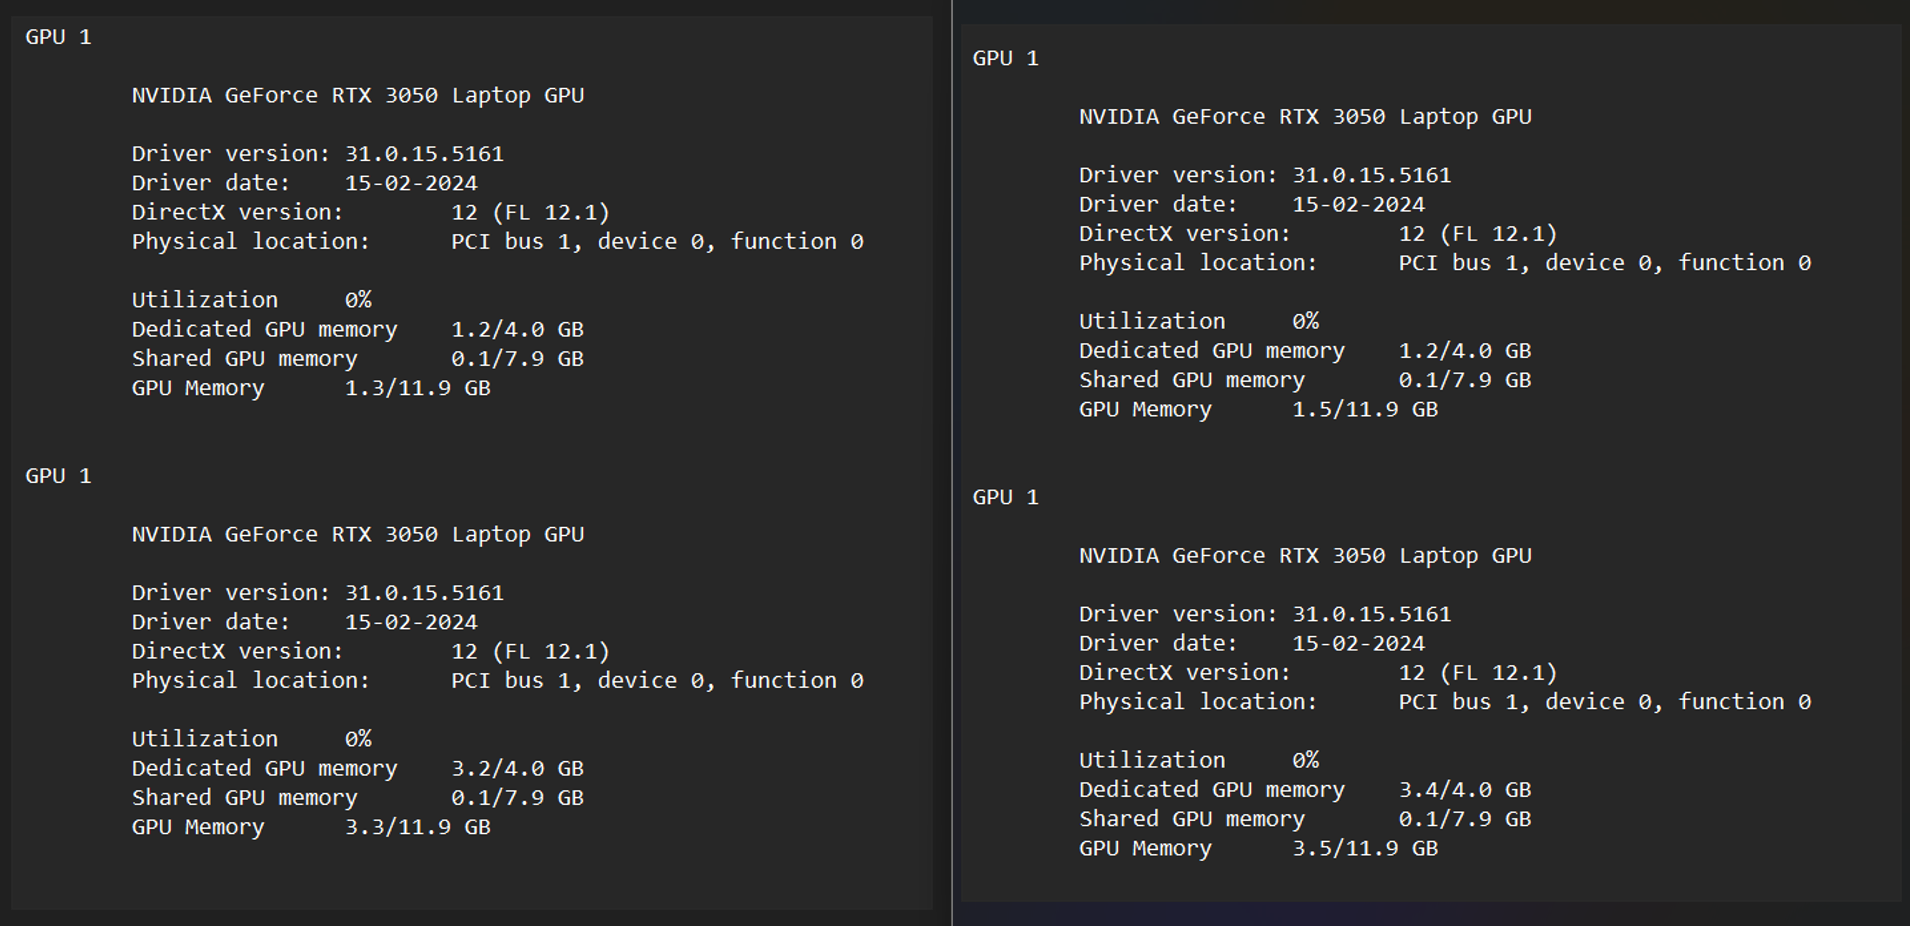


**Observation :** We can clearly see that fp16 uses less memory as compared to fp32. This is directly related to using 16 point floating representaion which requires less memory as compared to 32 point floating representation


The main difference in memory usage for a forward pass between FP32 and FP16 models comes down to the number of bits used to represent each number. Here's the breakdown:

- FP32 (32-bit floating-point): Uses 32 bits to represent a number. This allows for a wider range of values and higher precision.
- FP16 (16-bit floating-point): Uses only 16 bits to represent a number. This offers a smaller range of values and lower precision, but requires half the memory compared to FP32.

**Memory Usage Impact:**
In a forward pass, the model processes the input data through its layers. Since each number in the model's calculations is represented with half the bits in FP16 compared to FP32, the overall memory footprint of the model's activations and weights will be reduced by half. This translates to significant memory savings, especially for large models.

**Trade-off:**

While FP16 offers memory efficiency, there's a potential trade-off:

- Reduced Precision: Lower precision can lead to minor accuracy loss in some cases. However, the impact might be negligible for tasks like object recognition, where CLIP excels at understanding the bigger picture through relationships with text descriptions.

Therefore, using FP16 for CLIP's forward pass can significantly reduce memory usage without a significant impact on accuracy for certain tasks. This allows you to potentially run larger models or process more data on the same hardware.

